# Vaccine Sentiment Classification
*by Nefeli Tavoulari*

#### In this notebook I am using a dataset provided by Dr. Saptarshi Ghosh and Soham Poddar from the Department of Computer Science and Engineering, IIT Kharagpur, India. 

## Install Dependencies

In [1]:
!pip install langdetect

     |████████████████████████████████| 981 kB 5.2 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=d134576203137d8aa1b929e2d254324e2ad3b88e354aeb381a76cb6c640db06d
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


## Import Packages

In [70]:
%matplotlib inline
import io
import re
import csv
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
 
#from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
import langdetect
from langdetect import DetectorFactory

import sklearn as sk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Some Globals

In [3]:
porter = PorterStemmer()
lancaster = LancasterStemmer()
snowball = nltk.stem.SnowballStemmer('english')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
DetectorFactory.seed = 0

## Upload dataset - Create dataframe

In [4]:
upload_train = files.upload()

Saving vs_train.csv to vs_train.csv


In [5]:
upload_dev = files.upload()

Saving vs_dev.csv to vs_dev.csv


In [6]:
df = pd.read_csv(io.BytesIO(upload_train['vs_train.csv']))
df2 = pd.read_csv(io.BytesIO(upload_dev['vs_dev.csv']))

In [7]:
print(df)

       Unnamed: 0                                              tweet  label
0               0  Sip N Shop Come thru right now #Marjais #Popul...      0
1               1  I don't know about you but My family and I wil...      1
2               2  @MSignorile Immunizations should be mandatory....      2
3               3  President Obama spoke in favor of vaccination ...      0
4               4  "@myfoxla: Arizona monitoring hundreds for mea...      0
...           ...                                                ...    ...
15971       15971  @Salon if u believe the anti-vax nutcases caus...      1
15972       15972  How do you feel about parents who don't #vacci...      0
15973       15973  70 Preschoolers Tested for Measles in Simi Val...      0
15974       15974  Finance Minister: Budget offers room to procur...      0
15975       15975  Are you up to date on vaccines? Take CDC’s vac...      2

[15976 rows x 3 columns]


In [8]:
print(df2)

      Unnamed: 0                                              tweet  label
0              0  @user They had a massive surge in with covid d...      1
1              1  Required vaccines for school: Parents and guar...      0
2              2  “@KCStar: Two more Johnson County children hav...      0
3              3  NV can do better. Which states are the best (a...      2
4              4  Nothing like killing ourselves w/ our own fear...      2
...          ...                                                ...    ...
2277        2277  RT @abc7: Number of measles cases reported in ...      0
2278        2278  Evidence points to the idea that "measles affe...      0
2279        2279  Where's @SavedYouAClick "@voxdotcom: Why you s...      2
2280        2280  Some of my favorite people have autism. If tha...      2
2281        2281  Coronavirus: The married couple behind the suc...      0

[2282 rows x 3 columns]


## Remove empty tweets

In [9]:
df.dropna(subset = ["tweet"], inplace=True)
df2.dropna(subset = ["tweet"], inplace=True)

df.drop_duplicates(subset = ["tweet"], inplace=True)
print(df.shape)
print(df2.shape)

(15881, 3)
(2282, 3)


## Check dataset balance



In [10]:
df.groupby("label")["tweet"].count()

label
0    7385
1    2070
2    6426
Name: tweet, dtype: int64

## Text Preprocessing

In [11]:
def clean_text(text):

  text = text.lower()                                           # lowercase
  text = text.strip()                                           # remove white spaces
  text = ' '.join(re.sub("(@[A-Za-z0-9]+)"," ",text).split())   # remove twitter user accounts
  text = re.sub(r'http\S+', ' ', text)                          # remove urls
  text = re.sub('[^A-Za-z0-9]+', ' ', text)                     # remove special characters

  # perform stemming
  cleaned_text = ""
  for word in text.split() :
    if word in stop_words:                                      # remove stopwords
      continue
    temp = lemmatizer.lemmatize(word)                           # lemmatize
    #temp = snowball.stem(word)
    #temp = lancaster.stem(word)
    #temp = porter.stem(word)
    
    cleaned_text += (temp + " ")

  # tokenize
  #tokens = word_tokenize(cleaned_text)

  return cleaned_text


In [12]:
cleaned_text = []
for line in df["tweet"]:
  cleaned_text.append(clean_text(line))
cleaned_text_val = []
for line in df2["tweet"]:
  cleaned_text_val.append(clean_text(line))


## Create new column with clean text

In [13]:
df = df.assign(clean_tweet = lambda x: cleaned_text)
df2 = df2.assign(clean_tweet = lambda x: cleaned_text_val)

In [14]:
df

,Unnamed: 0,tweet,label,clean_tweet
0,0,Sip N Shop Come thru right now #Marjais #Popul...,0,sip n shop come thru right marjais popularnobo...
1,1,I don't know about you but My family and I wil...,1,know family take covid19 vaccine anytime soon
2,2,@MSignorile Immunizations should be mandatory....,2,immunization mandatory period oklahoma let kid...
3,3,President Obama spoke in favor of vaccination ...,0,president obama spoke favor vaccination child ...
4,4,"""@myfoxla: Arizona monitoring hundreds for mea...",0,arizona monitoring hundred measles linked disn...
...,...,...,...,...
15971,15971,@Salon if u believe the anti-vax nutcases caus...,1,u believe anti vax nutcase caused measles u ig...
15972,15972,How do you feel about parents who don't #vacci...,0,feel parent vaccinate kid measlesoutbreak
15973,15973,70 Preschoolers Tested for Measles in Simi Val...,0,70 preschooler tested measles simi valley
15974,15974,Finance Minister: Budget offers room to procur...,0,finance minister budget offer room procure cov...


In [15]:
df2

,Unnamed: 0,tweet,label,clean_tweet
0,0,@user They had a massive surge in with covid d...,1,massive surge covid death immediately vaccine ...
1,1,Required vaccines for school: Parents and guar...,0,required vaccine school parent guardian child ...
2,2,“@KCStar: Two more Johnson County children hav...,0,two johnson county child measles
3,3,NV can do better. Which states are the best (a...,2,nv better state best worst vaccinating kid
4,4,Nothing like killing ourselves w/ our own fear...,2,nothing like killing w fear mt milano vaccine ...
...,...,...,...,...
2277,2277,RT @abc7: Number of measles cases reported in ...,0,rt number measles case reported cali 10 year h...
2278,2278,"Evidence points to the idea that ""measles affe...",0,evidence point idea measles affect immune syst...
2279,2279,"Where's @SavedYouAClick ""@voxdotcom: Why you s...",2,vaccinate kid two minute
2280,2280,Some of my favorite people have autism. If tha...,2,favorite people autism reason bringing back di...


## Vectorize and Perform TF-IDF

### Training data

In [16]:
cv = CountVectorizer(stop_words='english')
word_count_vector_train = cv.fit_transform(df['clean_tweet'])
word_count_vector_train.shape

(15881, 17632)

In [17]:
tfidf_transformer = TfidfTransformer(smooth_idf = True, use_idf = True) 
tfidf_transformer.fit(word_count_vector_train)

# print idf values sorted by ascending order
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
df_idf.sort_values(by=['idf_weights'])

,idf_weights
vaccine,1.889699
measles,2.347151
kid,3.197036
child,3.226357
health,3.331458
...,...
ideal,9.979794
ideally,9.979794
ideapti,9.979794
identity,9.979794


In [18]:
# count matrix 
count_vector_train = cv.transform(df['clean_tweet']) 

# tf-idf scores 
tf_idf_vector = tfidf_transformer.transform(count_vector_train)

In [19]:
#get tf-idf vector for first tweet 
first_tweet_vector = tf_idf_vector[0] 
 
# print scores sorted by descending order
df3 = pd.DataFrame(first_tweet_vector.T.todense(), index=cv.get_feature_names() , columns=["tfidf"]) 
df3.sort_values(by=["tfidf"],ascending=False)

,tfidf
marjais,0.679812
sip,0.354301
sipnshop,0.354301
shop,0.321771
popularnobodies,0.315298
...,...
fascist,0.000000
fashion,0.000000
fashioned,0.000000
faso,0.000000


### Test Data

In [20]:
count_vector_dev = cv.transform(df2['clean_tweet']) 
tf_idf_vector_dev = tfidf_transformer.transform(count_vector_dev)
first_document_vector_dev = tf_idf_vector_dev[0] 
df4 = pd.DataFrame(first_document_vector_dev.T.todense(), index=feature_names, columns=["tfidf"]) 
df4.sort_values(by=["tfidf"], ascending=False)

,tfidf
entirety,0.380506
death,0.377915
immediately,0.327650
surge,0.309139
massive,0.289080
...,...
fashion,0.000000
fashioned,0.000000
faso,0.000000
fast,0.000000


## Perform Logistic Regression

In [21]:
x_train = pd.DataFrame.sparse.from_spmatrix(tf_idf_vector)
x_dev = pd.DataFrame.sparse.from_spmatrix(tf_idf_vector_dev)
y_train = df["label"]
y_dev = df2["label"]
x_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,17592,17593,17594,17595,17596,17597,17598,17599,17600,17601,17602,17603,17604,17605,17606,17607,17608,17609,17610,17611,17612,17613,17614,17615,17616,17617,17618,17619,17620,17621,17622,17623,17624,17625,17626,17627,17628,17629,17630,17631
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
LR = LogisticRegression(multi_class='multinomial', random_state = 0, max_iter = 1000)
LR.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
y_train_pred = LR.predict(x_train) #Return the predictions
LR.score(x_train, y_train)

0.8376676531704552

In [24]:
y_dev_pred = LR.predict(x_dev) #Return the predictions
LR.score(x_dev, y_dev)

0.724364592462752

## Precision, Recall, F1 score

In [25]:
precision_recall_fscore_support(y_train, y_train_pred, average='weighted')

(0.8417703441480432, 0.8376676531704552, 0.8320022393192505, None)

In [26]:
precision_recall_fscore_support(y_dev, y_dev_pred, average='weighted')

(0.7205656713371744, 0.724364592462752, 0.7175414514881094, None)

In [27]:
accuracy_score(y_train, y_train_pred)

0.8376676531704552

In [28]:
accuracy_score(y_dev, y_dev_pred)

0.724364592462752

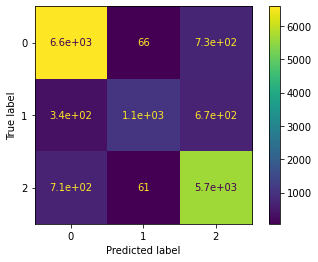

In [29]:
cm = confusion_matrix(y_train, y_train_pred, labels=LR.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LR.classes_)
disp.plot()
plt.show()

In [30]:
target_names = ['neutral', 'anti-vax', 'pro-vax']
print(classification_report(y_train, y_train_pred, target_names=target_names))
print(classification_report(y_dev, y_dev_pred, target_names=target_names))

              precision    recall  f1-score   support

     neutral       0.86      0.89      0.88      7385
    anti-vax       0.89      0.51      0.65      2070
     pro-vax       0.80      0.88      0.84      6426

    accuracy                           0.84     15881
   macro avg       0.85      0.76      0.79     15881
weighted avg       0.84      0.84      0.83     15881

              precision    recall  f1-score   support

     neutral       0.77      0.80      0.79      1065
    anti-vax       0.64      0.38      0.48       296
     pro-vax       0.69      0.75      0.72       921

    accuracy                           0.72      2282
   macro avg       0.70      0.64      0.66      2282
weighted avg       0.72      0.72      0.72      2282



## Same process using TfidfVectorizer

In [ ]:
tfidfvectorizer = TfidfVectorizer()

word_count_vector_train = tfidfvectorizer.fit_transform(df['clean_tweet'])
word_count_vector_dev = tfidfvectorizer.transform(df2['clean_tweet'])

x_train = pd.DataFrame.sparse.from_spmatrix(word_count_vector_train)
x_dev = pd.DataFrame.sparse.from_spmatrix(word_count_vector_dev)

scaler = StandardScaler()
#scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_dev = scaler.transform(x_dev)

#parameters={'penalty':['l2','none'],'C':[1,2,3,4,5], 'solver':['newton-cg', 'lbfgs', 'sag', 'saga'], 'multi_class':['multinomial'], 'max_iter':[100, 200, 500, 1000, 2000]}
#gscv = GridSearchCV(LR, parameters, scoring='accuracy', n_jobs=-1, cv=10)
#grid_search = gscv.fit(x_train, y_train)
#grid_search.best_params_

LR.fit(x_train, y_train)

## Precision, Recall, F1 score

In [57]:
y_train_pred = LR.predict(x_train) #Return the predictions
LR.score(x_train, y_train)

0.8371009382280713

In [59]:
y_dev_pred = LR.predict(x_dev) #Return the predictions
LR.score(x_dev, y_dev)

0.726555652936021

In [60]:
precision_recall_fscore_support(y_train, y_train_pred, average='weighted')

(0.8410722571627512, 0.8371009382280713, 0.831700555390568, None)

In [61]:
precision_recall_fscore_support(y_dev, y_dev_pred, average='weighted')

(0.7262620167181946, 0.726555652936021, 0.7203214776228821, None)

In [62]:
accuracy_score(y_train, y_train_pred)

0.8371009382280713

In [63]:
accuracy_score(y_dev, y_dev_pred)

0.726555652936021

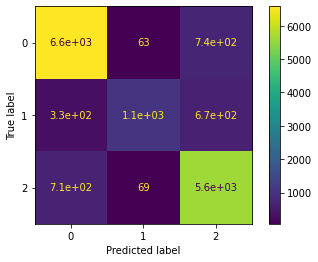

In [64]:
cm = confusion_matrix(y_train, y_train_pred, labels=LR.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LR.classes_)
disp.plot()
plt.show()

In [65]:
target_names = ['neutral', 'anti-vax', 'pro-vax']
print(classification_report(y_train, y_train_pred, target_names=target_names))
print(classification_report(y_dev, y_dev_pred, target_names=target_names))

              precision    recall  f1-score   support

     neutral       0.86      0.89      0.88      7385
    anti-vax       0.89      0.51      0.65      2070
     pro-vax       0.80      0.88      0.84      6426

    accuracy                           0.84     15881
   macro avg       0.85      0.76      0.79     15881
weighted avg       0.84      0.84      0.83     15881

              precision    recall  f1-score   support

     neutral       0.77      0.79      0.78      1065
    anti-vax       0.70      0.40      0.51       296
     pro-vax       0.69      0.75      0.72       921

    accuracy                           0.73      2282
   macro avg       0.72      0.65      0.67      2282
weighted avg       0.73      0.73      0.72      2282

